In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dlib
from skimage import io
import os
import time
from PIL import Image
from IPython.display import display
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.utils import to_categorical

In [2]:
directory = "NBA Players"

## The preparation of the Data

First we load all the images available of the different players

In [5]:
images = {}
for player in os.listdir(directory):
    f = os.path.join(directory, player)
    if os.path.isdir(f):
        player_images = []
        for filename in os.listdir(f):
            img = os.path.join(f, filename)
            if os.path.isfile(img):
                player_images.append(io.imread(img))
        images[player] = player_images

Here we have an example of image loaded:

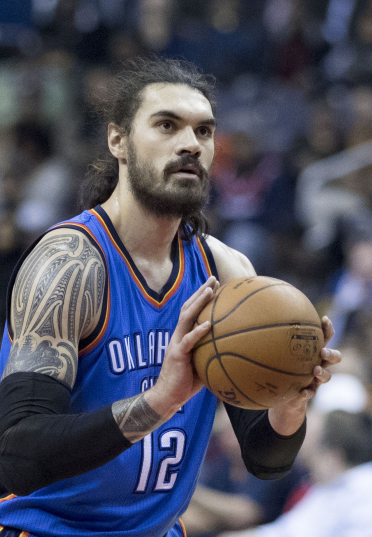

In [7]:
display(Image.fromarray(images['Adams, Steven'][3]).reduce(3))

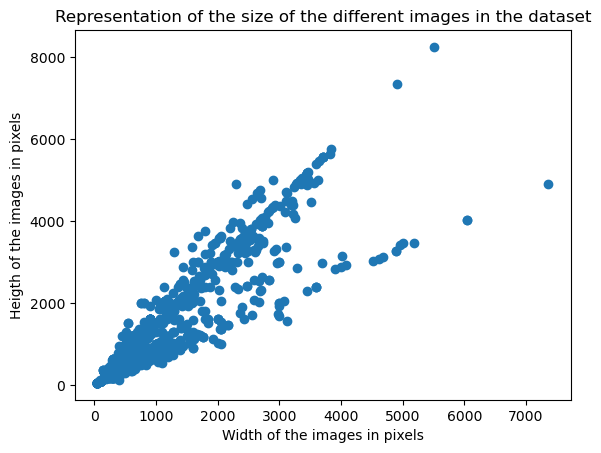

In [8]:
x_axis = []
y_axis = []

for player, imgs in images.items():
    for img in imgs:
        x_axis.append(len(img))
        y_axis.append(len(img[0]))

plt.scatter(x_axis, y_axis)
plt.xlabel('Width of the images in pixels')
plt.ylabel('Heigth of the images in pixels')
plt.title('Representation of the size of the different images in the dataset')
plt.show()

Here we can see that the images do not have the same shape and do not have the same sizes so next we are gonna analyze the different pictures to find the faces of the players and keep only the pictures where we are sure that those are pictures with only one face so we will keep only the faces of our players labeled to allow the training with good data.

In [10]:
faces = {}
face_detector = dlib.get_frontal_face_detector()
for player, imgs in images.items():
    player_faces = []
    for img in imgs:
        detected_faces = face_detector(img, 1)
        if (len(detected_faces) == 1):
            face_detected = detected_faces[0]
            crop_box = (face_detected.left(), face_detected.top(), face_detected.right(), face_detected.bottom())
            player_faces.append(Image.fromarray(img).crop(crop_box))
    faces[player] = player_faces

Here we have the same image as above but with only the faces that has been kepted for the future data training:

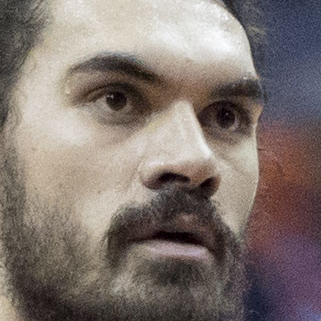

In [12]:
display(faces['Adams, Steven'][2])

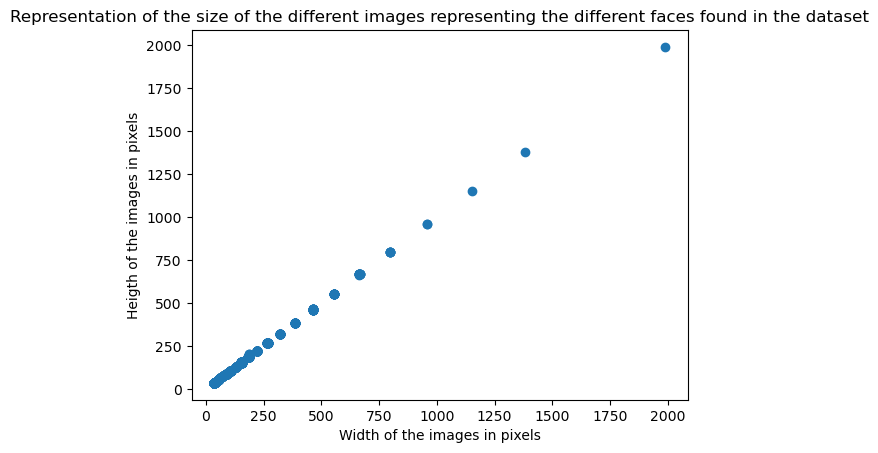

In [13]:
x_axis = []
y_axis = []

for player, imgs in faces.items():
    for img in imgs:
        x, y = img.size
        x_axis.append(x)
        y_axis.append(y)

plt.scatter(x_axis, y_axis)
plt.xlabel('Width of the images in pixels')
plt.ylabel('Heigth of the images in pixels')
plt.title('Representation of the size of the different images representing the different faces found in the dataset')
plt.show()

Now we can see that our pictures of the faces are squared so it will be easier for the resizing since we will not change the shapes of the different faces.

In [15]:
resized_images = {}

for player, faces_list in faces.items():
    resized_faces = []
    for face in faces_list:
        resized_faces.append(face.resize((100, 100)))
    resized_images[player] = resized_faces

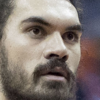

In [16]:
display(resized_images['Adams, Steven'][2])

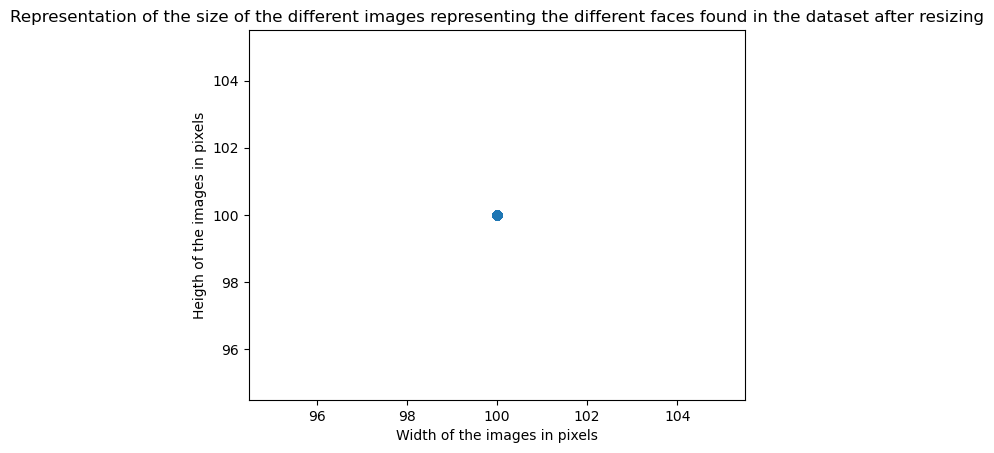

In [17]:
x_axis = []
y_axis = []

for player, imgs in resized_images.items():
    for img in imgs:
        x, y = img.size
        x_axis.append(x)
        y_axis.append(y)

plt.scatter(x_axis, y_axis)
plt.xlabel('Width of the images in pixels')
plt.ylabel('Heigth of the images in pixels')
plt.title('Representation of the size of the different images representing the different faces found in the dataset after resizing')
plt.show()

Now we can see that all our face images are the same size so we are ready to build our dataframe.

In [19]:
#For the treatment we use gray images since it should not impact too much our learning process but it will divide our data by 3.

df = pd.DataFrame()

for player, faces in resized_images.items():
    df_data = []
    for face in faces:
        gray_image = face.convert('L')
        image_array = np.array(gray_image)
        image_array = np.reshape(image_array, -1)
        df_data.append(image_array)
    current_player_df = pd.DataFrame(df_data)
    current_player_df['player'] = player
    df = pd.concat([df, current_player_df])
df

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,player
0,22,23,23,22,23,22,21,21,21,20,...,95,95,99,106,80,27,24,23,23,"Aminu, Al-Farouq"
1,32,28,30,31,31,38,39,40,32,32,...,13,14,13,13,13,12,13,13,13,"Aminu, Al-Farouq"
2,13,28,23,11,21,27,31,33,35,39,...,250,244,242,233,198,204,220,219,224,"Aminu, Al-Farouq"
3,118,105,99,107,119,100,120,129,149,153,...,163,163,162,163,167,172,178,182,185,"Aminu, Al-Farouq"
4,2,3,2,2,5,7,8,8,16,29,...,240,242,245,230,172,122,82,61,59,"Aminu, Al-Farouq"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27,99,100,104,105,108,115,126,139,149,156,...,121,118,117,118,121,125,129,132,133,"Barea, J.J"
28,18,19,22,26,28,28,26,26,28,30,...,164,113,80,60,48,45,51,57,57,"Barea, J.J"
29,48,48,48,48,48,47,46,45,43,42,...,63,69,91,104,99,100,106,107,105,"Barea, J.J"
30,104,103,101,100,102,101,100,103,96,90,...,39,41,37,42,43,39,41,43,47,"Barea, J.J"


## Training using Scikit Learn library

In [21]:
X = df.drop('player', axis = 1)
y = df['player']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
models = {
    'mlp': MLPClassifier(),
    'adaBst': AdaBoostClassifier(algorithm='SAMME'),
    'rdmFst': RandomForestClassifier()
}

In [24]:
results = []

for i, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])
    start_time = time.time()
    pipeline.fit(X, y)
    fit_time = time.time() - start_time
    train_score = pipeline.score(X_train, y_train)
    test_score = pipeline.score(X_test, y_test)
    results.append([type(model).__name__, fit_time, train_score, test_score])
results_df = pd.DataFrame(results, columns=['Model', 'Train Time', 'Train Accuracy', 'Test Accuracy'])
results_df.set_index('Model', inplace=True)
results_df

,Train Time,Train Accuracy,Test Accuracy
Model,,,
MLPClassifier,24.107157,0.996139,1.000000
AdaBoostClassifier,27.177716,0.140283,0.132132
RandomForestClassifier,7.038386,0.996139,1.000000


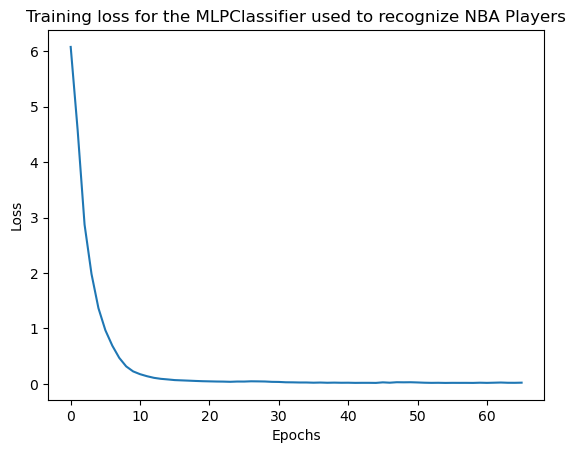

In [25]:
plt.plot(models['mlp'].loss_curve_)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss for the MLPClassifier used to recognize NBA Players')
plt.show()
plt.show()

## Training using Keras

In [27]:
scaled_X = pd.DataFrame(StandardScaler().fit_transform(df.drop('player', axis = 1)))
X = scaled_X.iloc[:,0:int(len(scaled_X.columns)/100)].to_numpy()
for i in range(1, 100):
    X = np.dstack((X, scaled_X.iloc[:,int(len(scaled_X.columns)/100) * i:int(len(scaled_X.columns)/100) * (i + 1)]))
X.shape

(1110, 100, 100)

Here we first scale our data even if it should not impact too much since the data was already on a common scale, then we rebuild the image in a numpy array to be able to feed it to our Neural Network.

In [29]:
y = df['player']
players = list(resized_images.keys())
y = y.apply(lambda player: players.index(player))
y = to_categorical(y)
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

Here we make the data in a format where each output will be represented by an array where we will find one value at 1 and 0 to all the others; each index will represent the name of one player. This data will allow us to feed this expected output to the Neural Network.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [32]:
conv_model = Sequential([
    Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu'),
    MaxPool2D(pool_size = (2, 2)),
    Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu'),
    MaxPool2D(pool_size = (2, 2)),
    Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'),
    MaxPool2D(pool_size = (2, 2)),
    Conv2D(filters = 128, kernel_size = (3, 3), activation = 'relu'),
    MaxPool2D(pool_size = (2, 2)),
    Conv2D(filters = 256, kernel_size = (3, 3), activation = 'relu'),
    Flatten(),
    Dense(len(images), activation = 'softmax')
])
conv_model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

For our Neural Network we will have 5 convolutional layers and in between each of them we will have a layer that will reduce our image by half. At the end we will finish with a dense layer that will have the number of player as dimensionality and will return the player found using a softmax method.

In [34]:
conv_model.build(input_shape = (X_train.shape[0], 100, 100, 1))
conv_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (999, 98, 98, 16)      │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (999, 49, 49, 16)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (999, 47, 47, 32)      │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (999, 23, 23, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (999, 21, 21, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (999, 10, 10, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (999, 8, 8, 128)       │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (999, 4, 4, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (999, 2, 2, 256)       │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (999, 1024)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (999, 29)              │        29,725 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 422,045 (1.61 MB)

 Trainable params: 422,045 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
history = conv_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.0458 - loss: 3.3463 - val_accuracy: 0.0541 - val_loss: 3.2617
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0932 - loss: 3.1452 - val_accuracy: 0.0991 - val_loss: 3.0897
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.1520 - loss: 2.9205 - val_accuracy: 0.0811 - val_loss: 3.0865
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.1901 - loss: 2.7818 - val_accuracy: 0.1351 - val_loss: 2.9423
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3133 - loss: 2.3859 - val_accuracy: 0.1982 - val_loss: 2.8803
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4405 - loss: 2.0284 - val_accuracy: 0.1622 - val_loss: 2.8757
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.4900 - loss: 1.7468 - val_accuracy: 0.2252 - val_loss: 3.2162
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6555 - loss: 1.1859 - val_accuracy: 0.2523 - v

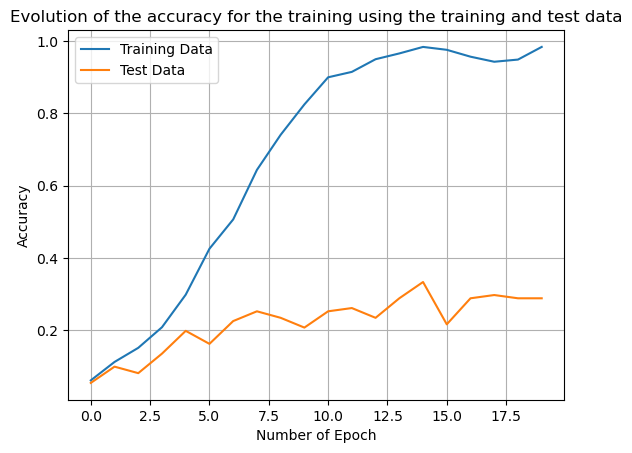

In [36]:
plt.plot(history.history['accuracy'], label = 'Training Data')
plt.plot(history.history['val_accuracy'], label = 'Test Data')
plt.title('Evolution of the accuracy for the training using the training and test data')
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend();

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


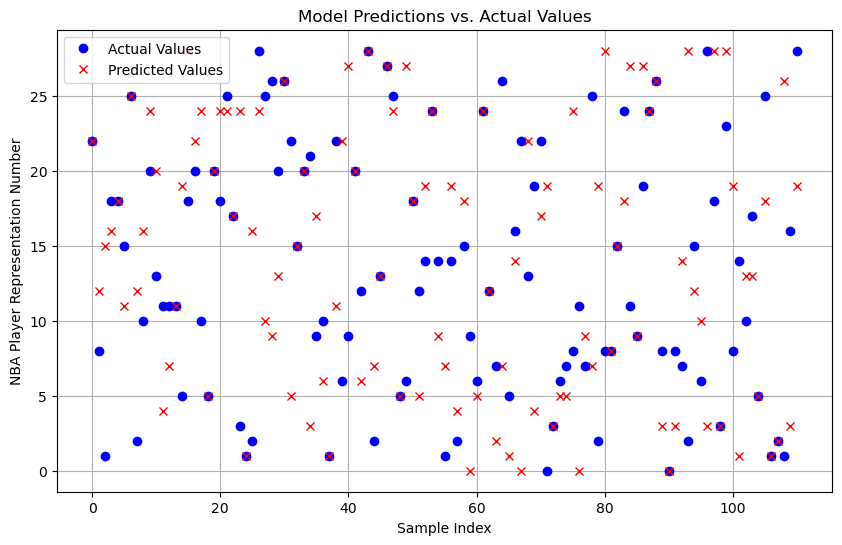

In [37]:
pred_classes = conv_model.predict(X_test)
pred_classes = np.argmax(pred_classes, axis=1)
y_classes_prediciton = np.argmax(y_test, axis=1)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(y_classes_prediciton, label='Actual Values', color='blue', linestyle="", marker="o")
plt.plot(pred_classes, label='Predicted Values', color='red', linestyle="", marker="x")
plt.title('Model Predictions vs. Actual Values')
plt.xlabel('Sample Index')
plt.ylabel('NBA Player Representation Number')
plt.grid()
plt.legend()
plt.show()

The result of the experiment with Neural Network is actually not satisfying. Unfortunately I think the reason is that we are not having enough data for our training since I did some additional experiments and I realized that the more data I was keeping for the training, the best the results were. With 30% of our data reserved for testing we were around 20-22% of success on the dataset, with 20% we were around 26-27% and finally as we can see here with 10% for the testing we can reach 32-34%. My conclusion is that I don't think the results are improving because the test dataset is smaller, in our case it stays big enough; but I think we need more data to have a proper training for the neural network so for this specific case I would not go with a neural network (at least not one from scratch, another possibility could be to work on a pretrained one) but long term if we could increase our batch of data I would definitely reconsider.

## Conclusion
The execution showed us that the recognition of the players have been very efficient using the MLPClassifier and the RandomForestClassifier; unfortunately we also could've had good results with the Neural Network built using Keras but it seems that we have missed of data so in this case it could be interesting long term if the data grow to switch to a Neural Network using Keras. As a final choice I would prefer to use RandomForestClassifier since it is a deterministic approach, it is also a lot faster to train the RandomForestClassifier compare to the MLPClassifier, finally, the number of player in NBA is fixed and the changes of team can be done only at certain time of the year so we would not need to retrain the data very often.